## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['SNORKELDB'] = 'postgres:///babble_spouse_demo'

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

In [4]:
from snorkel.contrib.babble.pipelines import config

config = configuration
config['domain'] = 'spouse'
config['splits'] = [0,1,2]
config['parallelism'] = 6
config['verbose'] = True
config['display_learned_accuracies'] = False

In [5]:
from snorkel.models import candidate_subclass
from snorkel.contrib.babble import ExplanationIO
from tutorials.babble.spouse import SpousePipeline

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
candidate_class = Spouse
sm = SpousePipeline(session, Spouse, config)

## Parse, Extract, Load Gold

In [6]:
%time sm.parse()

Clearing existing...
Running UDF...
Documents: 2591
Sentences: 67820
CPU times: user 2min 44s, sys: 3.15 s, total: 2min 47s
Wall time: 3min 34s


In [7]:
%time sm.extract()

Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 0]: 23490
Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 1]: 2456
Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 2]: 1820
CPU times: user 6min 15s, sys: 5.68 s, total: 6min 21s
Wall time: 7min 16s


In [8]:
%time sm.load_gold()

AnnotatorLabels created: 1201
AnnotatorLabels created: 2370
AnnotatorLabels created: 1747
CPU times: user 2min 3s, sys: 2.8 s, total: 2min 6s
Wall time: 2min 36s


##  Gather Explanations

Here we define a few convenient lists of words that the user can refer to when writing explanations. 

In [9]:
from tutorials.babble.spouse.spouse_examples import get_user_lists
user_lists = get_user_lists()
print("User lists: {}".format(user_lists.keys()))

User lists: ['known_spouses', 'spouse', 'other', 'family', 'last_names']


For example, the 'spouse' list contains a number of spouse-related words:

In [10]:
user_lists['spouse']

['spouse', 'wife', 'husband', 'ex-wife', 'ex-husband']

We have written 10 explanations as a starting point. We 'link' them to the candidates that they refer to by storing with each one a pointer to the candidate that the explanation was given in reference to.

In [11]:
candidates = session.query(candidate_class).filter(
    candidate_class.split == config['babbler_candidate_split']).all()

In [12]:
from tutorials.babble.spouse.spouse_examples import get_explanations
explanations = get_explanations(candidates)

Building list of target candidate ids...
Collected 11 unique target candidate ids from 11 explanations.
Gathering desired candidates...
Found 11/11 desired candidates
Linking explanations to candidates...
Linked 11/11 explanations


In [13]:
for exp in explanations:
    print(exp.condition)

there is a spouse word between arg 1 and arg 2
there is a spouse word within two words to the left of arg 1 or arg 2
there are no spouse words in the sentence
the word 'and' is between arg 1 and arg 2 and 'married' or 'marriage' is after arg 2
there is a family word between arg 1 and arg 2
there is a family word within three words to the left of arg 1 or arg 2
there is an other word between arg 1 and arg 2
either the pair of arg 1 and arg 2 or the pair arg 2 and arg 1 is in known_spouses
the number of words between arg 1 and arg 2 is larger than 10
there is a person between arg 1 and arg 2
arg 1 is identical to arg 2


## Apply Filter Bank

This step can be executed all at once with a single command:

```sm.babble(explanations, user_lists=user_lists, config=config)```

Because we would like to inspect the results between each step for illustration purposes, however, we will break it up into intermediate steps.

First, we create a ```Babbler``` object.

In [14]:
from snorkel.contrib.babble import Babbler

babbler = Babbler(mode='text', 
                  explanations=explanations, 
                  candidate_class=candidate_class, 
                  user_lists=user_lists)

Created grammar with 480 rules


No we use our semantic parser to convert the explanations into labeling functions (LFs).

In [15]:
lfs = babbler.generate_lfs()

24 parses created from 11 out of 11 explanation(s)
Parsed 24 LFs from 11 explanations.


Due to the ambiguity of natural language, we have more than twice as many candidate LFs as explanations. We now apply the filters in our filter bank to remove as many spurious LFs as possible without requiring additional labels.

First, if any parses have identical semantics (i.e., they represent the same program), remove all but one copy.

In [16]:
babbler.filter_duplicate_semantics()

Filtered to 20 LFs with duplicate semantics filter (4 filtered).


Next, remove any candidate LFs who label their accompanying candidate inconsistently with the label the user gave when providing the explanation.

In [17]:
babbler.filter_consistency()

Filtered to 13 LFs with consistency filter (7 filtered).


Now apply the remaining LFs to the full candidate set to observe their labeling signatures.

In [18]:
babbler.generate_label_matrix(split=0)

Clearing existing...
Running UDF...
[========================================] 100%



<23490x13 sparse matrix of type '<type 'numpy.int64'>'
	with 92389 stored elements in Compressed Sparse Row format>

Remove any LFs that label all candidates True or all candidates False. (In this case, either no LFs of this type were generated or they were removed by previous filters).

In [19]:
babbler.filter_uniform_signatures()

Filtered to 13 LFs with uniform signatures filter (0 filtered).


Then remove any LFs that have a duplicate labeling signature (i.e., even though they are technically different programs, since they have different semantics, they are effectively the same in this domain and therefore provide no unique information).

In [20]:
babbler.filter_duplicate_signatures()

Filtered to 10 LFs with duplicate signatures filter (3 filtered).


The actual parsed labeling functions are lambda functions ready to operate on candidates, which are hard to interpret directly. We can, however, view the explicit semantics of the remaining LFs or pseudocode versions of them (default).

In [21]:
babbler.get_parses(translate=True)

["return 1 if (call(in text(between([arg1,arg2])), 'and') and any(map(in text(right(arg2)), ['married','marriage']))) else 0",
 "return 1 if any(map(in $'known_spouses'$, [tuple([text(arg1),text(arg2)]),tuple([text(arg2),text(arg1)])])) else 0",
 "return -1 if any(map(in text(left(arg2,'.leq',3,'words')), $'family'$)) else 0",
 'return -1 if call((= text(arg2)), text(arg1)) else 0',
 "return -1 if call((= 0), sum(map(in text(sentence()), $'spouse'$))) else 0",
 "return -1 if any(map(in text(between([arg1,arg2])), $'other'$)) else 0",
 'return 1 if call((>= 1), count(filter(between([arg1,arg2]), words, \\w+\\S*))) else 0',
 "return 1 if any(map(in text(left(arg2,'.leq',2,'words')), $'spouse'$)) else 0",
 'return -1 if call((>= 1), count(filter(between([arg1,arg2]), ner_tags, PERSON))) else 0',
 'return -1 if call((> 10), count(between([arg1,arg2]))) else 0']

These parses correspond to the following explanations:

In [22]:
babbler.get_explanations()

[Explanation("LF_arg1_and_arg2_married: True, the word 'and' is between arg 1 and arg 2 and 'married' or 'marriage' is after arg 2"),
 Explanation("LF_distant: True, either the pair of arg 1 and arg 2 or the pair arg 2 and arg 1 is in known_spouses"),
 Explanation("LF_family_to_left: False, there is a family word within three words to the left of arg 1 or arg 2"),
 Explanation("LF_identical_args: False, arg 1 is identical to arg 2"),
 Explanation("LF_no_spouse_in_sentence: False, there are no spouse words in the sentence"),
 Explanation("LF_other_between: False, there is an other word between arg 1 and arg 2"),
 Explanation("LF_spouse_between: True, there is a spouse word between arg 1 and arg 2"),
 Explanation("LF_spouse_to_left: True, there is a spouse word within two words to the left of arg 1 or arg 2"),
 Explanation("LF_third_wheel: False, there is a person between arg 1 and arg 2"),
 Explanation("LF_too_far_apart: False, the number of words between arg 1 and arg 2 is larger than 

We now store the results from the Babbler in the SpousePipeline object for the sake of later stages in the pipeline.

In [23]:
from snorkel.annotations import LabelAnnotator

sm.babbler = babbler
sm.lfs = babbler.lfs
sm.labeler = LabelAnnotator(lfs=babbler.lfs)

## Aggregate Labels

In [24]:
%time sm.label(config=config)

Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 0: (23490,10) sparse (nnz = 66916)
Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 1: (2456,10) sparse (nnz = 7156)
CPU times: user 3min 35s, sys: 5.43 s, total: 3min 40s
Wall time: 4min 38s


/Users/bradenjh/repos/snorkel/snorkel/annotations.py:129: RuntimeWarning: invalid value encountered in divide
  ac = (tp+tn).astype(float) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_spouse_between_0,0,0.964984,0.940554,0.919788,174,2112,0,0,0.076115
LF_spouse_to_left_0,1,0.051303,0.051303,0.030945,79,45,0,0,0.637097
LF_no_spouse_in_sentence_0,2,0.822068,0.795195,0.792752,0,0,59,1884,0.969635
LF_arg1_and_arg2_married_3,3,0.009772,0.009772,0.008143,10,13,0,0,0.434783
LF_family_to_left_0,4,0.077769,0.077362,0.076140,0,0,7,174,0.961326
LF_other_between_0,5,0.026873,0.026873,0.026873,0,0,3,62,0.953846
LF_distant_0,6,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_too_far_apart_0,7,0.556596,0.556596,0.556596,0,0,75,1242,0.943052
LF_third_wheel_0,8,0.355456,0.355456,0.355456,0,0,32,813,0.962130
LF_identical_args_0,9,0.048860,0.048453,0.047231,0,0,0,118,1.000000


Inferred cardinality: 2


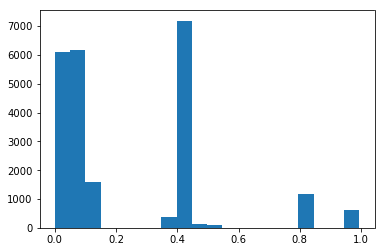

CPU times: user 1min 13s, sys: 305 ms, total: 1min 14s
Wall time: 1min 14s


In [25]:
%time sm.supervise(config=config)

## Classify

In [26]:
%time sm.classify()

/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 114 has argument past max length for model:	[arg ends at index 148; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:35: UserWarning: Additional warnings of this nature will be suppressed.
  warnings.warn('Additional warnings of this nature will be suppressed.')
/Users/bradenjh/anaconda/envs/snorkel/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3606  #epochs=10  batch size=256
[reRNN] Epoch 0 (5.03s)	Average loss=0.686136	Dev F1=23.18
[reRNN] Epoch 1 (11.02s)	Average loss=0.563439	Dev F1=27.84
[reRNN] Epoch 2 (17.87s)	Average loss=0.476397	Dev F1=21.99
[reRNN] Epoch 3 (24.33s)	Average loss=0.448705	Dev F1=19.80
[reRNN] Epoch 4 (30.59s)	Average loss=0.425984	Dev F1=20.69
[reRNN] Epoch 5 (36.80s)	Average loss=0.420339	Dev F1=19.58
[reRNN] Epoch 6 (42.94s)	Average loss=0.413609	Dev F1=19.78
[reRNN] Epoch 7 (49.19s)	Average loss=0.403157	Dev F1=22.89
[reRNN] Epoch 8 (55.98s)	Average loss=0.394193	Dev F1=22.00
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (64.53s)	Average loss=0.395278	Dev F1=21.60
[reRNN] Training done (66.01s)
[reRNN] Loaded model <reRNN>

Dev:


/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 146 has argument past max length for model:	[arg ends at index 130; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


Prec: 0.134, Recall: 0.612, F1 Score: 0.220

Test:


/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 226 has argument past max length for model:	[arg ends at index 100; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


Prec: 0.136, Recall: 0.707, F1 Score: 0.228
Scores (Un-adjusted)
Pos. class accuracy: 0.707
Neg. class accuracy: 0.596
Precision            0.136
Recall               0.707
F1                   0.228
----------------------------------------
TP: 106 | FP: 674 | TN: 996 | FN: 44

CPU times: user 6min 47s, sys: 42.4 s, total: 7min 29s
Wall time: 2min 2s


In [27]:
test_candidates = session.query(candidate_class).filter(
    candidate_class.split == 2).all()

In [28]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<1820x1 sparse matrix of type '<type 'numpy.int64'>'
	with 1747 stored elements in Compressed Sparse Row format>

In [29]:
tp, fp, tn, fn = sm.disc_model.error_analysis(session, test_candidates, L_gold_test, b=0.85)

Scores (Un-adjusted)
Pos. class accuracy: 0.24
Neg. class accuracy: 0.951
Precision            0.308
Recall               0.24
F1                   0.27
----------------------------------------
TP: 36 | FP: 81 | TN: 1589 | FN: 114



## Compare to Traditional Supervision

In [30]:
config['traditional'] = 1000

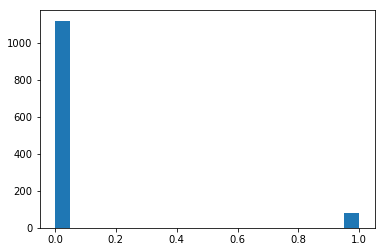

In [31]:
sm.supervise(config=config)

In [32]:
sm.classify()

/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 49 has argument past max length for model:	[arg ends at index 126; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


[reRNN] Training model
[reRNN] n_train=160  #epochs=10  batch size=160
[reRNN] Epoch 0 (0.34s)	Average loss=0.691312	Dev F1=13.69
[reRNN] Epoch 1 (1.92s)	Average loss=0.675484	Dev F1=13.10
[reRNN] Epoch 2 (3.40s)	Average loss=0.637015	Dev F1=8.35
[reRNN] Epoch 3 (4.91s)	Average loss=0.551792	Dev F1=12.71
[reRNN] Epoch 4 (6.38s)	Average loss=0.499583	Dev F1=12.71
[reRNN] Epoch 5 (7.87s)	Average loss=0.428732	Dev F1=12.44
[reRNN] Epoch 6 (9.34s)	Average loss=0.327734	Dev F1=11.12
[reRNN] Epoch 7 (10.94s)	Average loss=0.258298	Dev F1=9.37
[reRNN] Epoch 8 (12.66s)	Average loss=0.246120	Dev F1=8.41
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (15.48s)	Average loss=0.184064	Dev F1=11.07
[reRNN] Model saved as <reRNN>
[reRNN] Training done (18.59s)
[reRNN] Loaded model <reRNN>

Dev:
Prec: 0.063, Recall: 0.466, F1 Score: 0.111

Test:
Prec: 0.078, Recall: 0.500, F1 Score: 0.135
Scores (Un-adjusted)
Pos. class accuracy: 0.5
Neg. class accuracy: 0.469
Precision            0.078
Recall          

In [33]:
tp, fp, tn, fn = sm.disc_model.error_analysis(session, test_candidates, L_gold_test, b=0.05)

Scores (Un-adjusted)
Pos. class accuracy: 0.78
Neg. class accuracy: 0.247
Precision            0.0852
Recall               0.78
F1                   0.154
----------------------------------------
TP: 117 | FP: 1257 | TN: 413 | FN: 33



## Adding More Explanations

In [34]:
train_candidates = session.query(candidate_class).filter(
    candidate_class.split == 0).all()

In [35]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(train_candidates[500:600], session, n_per_page=3, height=300)
sv

<IPython.core.display.Javascript object>

In [36]:
from snorkel.contrib.babble import Explanation

babbler.add_explanations(
    Explanation(
        label=False,
        condition="'role as' is between arg 1 and arg 2",
        candidate=sv.get_selected()
    )
)